In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import warnings
from colorama import Fore, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
from lightgbm import LGBMClassifier, log_evaluation
import lightgbm
from catboost import Pool, CatBoostClassifier
import catboost
from wandb.lightgbm import wandb_callback, log_summary
import wandb

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kdimon15. Use `wandb login --relogin` to force relogin


True

In [2]:
def amex_metric(y_true, y_pred, return_components=False) -> float:
    def top_four_percent_captured(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

In [3]:
CFG = {
    'num_folds': 5,


    'lgbm': {
        'num_estimators': 195,
        'min_child_samples': 2400,
        'num_leaves': 127,
        'max_bins': 511
    },

    'make_submit': True,
    'seed': 777
}

In [4]:
features_avg = ['B_1', 'B_11', 'B_16', 'B_17', 'B_18', 'B_2', 'B_20',
                'B_28', 'B_3', 'B_4', 'B_5', 'B_7', 'B_9', 'D_112',
                'D_121', 'D_141', 'D_39', 'D_41', 'D_42', 'D_43',
                'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 
                'D_50', 'D_51', 'D_53', 'D_54', 'D_56', 'D_58', 
                'D_59', 'D_60', 'D_91', 'P_2', 'P_3', 'R_1', 'R_2', 
                'R_27', 'R_3', 'R_7', 'S_11', 'S_26', 'S_3', 'S_5']
features_last = ['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_15', 'B_16',
                 'B_17', 'B_18', 'B_19', 'B_2', 'B_20', 'B_22', 'B_23',
                 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_3',
                 'B_32', 'B_33', 'B_36', 'B_38', 'B_39', 'B_4', 'B_40',
                 'B_41', 'B_42', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9',
                 'D_102', 'D_103', 'D_105', 'D_106', 'D_107', 'D_109',
                 'D_112', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120',
                 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 
                 'D_129', 'D_132', 'D_133', 'D_135', 'D_136', 'D_137', 
                 'D_140', 'D_141', 'D_143', 'D_145', 'D_39', 'D_41',
                 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48',
                 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55',
                 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63',
                 'D_64', 'D_66', 'D_70', 'D_72', 'D_73', 'D_74', 'D_75',
                 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_82', 'D_83',
                 'D_84', 'D_86', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96',
                 'P_2', 'P_3', 'R_1', 'R_10', 'R_11', 'R_12', 'R_13',
                 'R_14', 'R_15', 'R_17', 'R_18', 'R_19', 'R_2', 'R_20', 
                 'R_21', 'R_22', 'R_24', 'R_25', 'R_26', 'R_27', 'R_3',
                 'R_4', 'R_5', 'R_7', 'R_8', 'R_9', 'S_11', 'S_12',
                 'S_13', 'S_15', 'S_17', 'S_20', 'S_22', 'S_23', 
                 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6',
                 'S_7', 'S_8', 'S_9']

In [5]:
def get_data(path, train=False):
    data = pd.read_feather(path)
    cid = pd.Categorical(data.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1))
    if train: target = data.loc[last, 'target']
    df_avg = data[features_avg].groupby(cid).mean().rename(columns={f: f"{f}_avg" for f in features_avg})
    data = data.loc[last, features_last].rename(columns={f: f"{f}_last" for f in features_last}).set_index(np.asarray(cid[last]))
    data = pd.concat([data, df_avg], axis=1)
    if train: return data, target
    else: return data

train_data, target = get_data('data/train_data.ftr', train=True)
test_data = get_data('data/test_data.ftr')
gc.collect()

0

In [6]:
def my_booster(random_state=CFG['seed'], n_estimators=CFG['lgbm']['num_estimators']):
    return LGBMClassifier(n_estimators=n_estimators,
                          min_child_samples=CFG['lgbm']['min_child_samples'],
                          num_leaves=CFG['lgbm']['num_leaves'],
                          max_bins=CFG['lgbm']['max_bins'], random_state=random_state)

features = [f for f in train_data.columns if f not in ('customer_ID', 'target')]

score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=CFG['num_folds'], random_state=CFG['seed'], shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_data, target)):
    start_time = datetime.datetime.now()
    X_tr = train_data.iloc[idx_tr][features]
    X_va = train_data.iloc[idx_va][features]
    y_tr = target.iloc[idx_tr]
    y_va = target.iloc[idx_va]

    train_ds = lightgbm.Dataset(X_tr, y_tr)
    valid_ds = lightgbm.Dataset(X_va, y_va)

    wandb.init(project="kaggle_amex_v1", name=f'fold_{fold}', entity="kdimon15", job_type='train', config=CFG)
    model = my_booster()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_tr, y_tr,
                  eval_set = [(X_tr, y_tr),(X_va, y_va)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(30), wandb_callback()])

    y_va_pred = model.predict_proba(X_va)[:,1]
    score = amex_metric(y_va.values, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    y_pred_list.append(model.predict_proba(test_data[features])[:,1])
    gc.collect()
    
    wandb.join()
print(f"{Fore.RED}{Style.BRIGHT}OOF Score:   {np.mean(score_list):.5f}{Style.RESET_ALL}")

[30]	training's binary_logloss: 0.236651	training's amex: 0.777975	valid_1's binary_logloss: 0.240483	valid_1's amex: 0.767157
[60]	training's binary_logloss: 0.212691	training's amex: 0.801302	valid_1's binary_logloss: 0.223911	valid_1's amex: 0.781727
[90]	training's binary_logloss: 0.19996	training's amex: 0.818536	valid_1's binary_logloss: 0.220406	valid_1's amex: 0.787002
[120]	training's binary_logloss: 0.189755	training's amex: 0.833271	valid_1's binary_logloss: 0.219425	valid_1's amex: 0.788133
[150]	training's binary_logloss: 0.180585	training's amex: 0.846823	valid_1's binary_logloss: 0.219142	valid_1's amex: 0.789172
[180]	training's binary_logloss: 0.172004	training's amex: 0.861257	valid_1's binary_logloss: 0.219095	valid_1's amex: 0.788971
Fold 0 | 02:24 |   195 trees |                Score = 0.78888


iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_amex,▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
training_binary_logloss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_amex,▁▃▃▄▅▅▆▆▆▇▇▇▇▇▇█████████████████████████
valid_1_binary_logloss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,194
training_amex,0.86791
valid_1_amex,0.78888


[30]	training's binary_logloss: 0.236013	training's amex: 0.777581	valid_1's binary_logloss: 0.242509	valid_1's amex: 0.764555
[60]	training's binary_logloss: 0.212161	training's amex: 0.802261	valid_1's binary_logloss: 0.226407	valid_1's amex: 0.78102
[90]	training's binary_logloss: 0.19947	training's amex: 0.819562	valid_1's binary_logloss: 0.222725	valid_1's amex: 0.786297
[120]	training's binary_logloss: 0.189288	training's amex: 0.832752	valid_1's binary_logloss: 0.221623	valid_1's amex: 0.787259
[150]	training's binary_logloss: 0.180005	training's amex: 0.847332	valid_1's binary_logloss: 0.221568	valid_1's amex: 0.787473
[180]	training's binary_logloss: 0.171489	training's amex: 0.861359	valid_1's binary_logloss: 0.221834	valid_1's amex: 0.787531
Fold 1 | 02:21 |   195 trees |                Score = 0.78673


iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_amex,▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
training_binary_logloss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_amex,▁▃▄▅▅▅▆▆▆▇▇▇▇▇██████████████████████████
valid_1_binary_logloss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,194
training_amex,0.86834
valid_1_amex,0.78673


[30]	training's binary_logloss: 0.236286	training's amex: 0.7784	valid_1's binary_logloss: 0.241278	valid_1's amex: 0.767263
[60]	training's binary_logloss: 0.212621	training's amex: 0.801604	valid_1's binary_logloss: 0.224845	valid_1's amex: 0.781345
[90]	training's binary_logloss: 0.199992	training's amex: 0.8183	valid_1's binary_logloss: 0.221134	valid_1's amex: 0.786196
[120]	training's binary_logloss: 0.189726	training's amex: 0.832289	valid_1's binary_logloss: 0.219818	valid_1's amex: 0.788733
[150]	training's binary_logloss: 0.180535	training's amex: 0.84662	valid_1's binary_logloss: 0.219424	valid_1's amex: 0.788517
[180]	training's binary_logloss: 0.171991	training's amex: 0.860583	valid_1's binary_logloss: 0.219266	valid_1's amex: 0.789917
Fold 2 | 02:21 |   195 trees |                Score = 0.78883


iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_amex,▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
training_binary_logloss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_amex,▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇████████████████████████
valid_1_binary_logloss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,194
training_amex,0.86733
valid_1_amex,0.78883


[30]	training's binary_logloss: 0.236403	training's amex: 0.778604	valid_1's binary_logloss: 0.242128	valid_1's amex: 0.767789
[60]	training's binary_logloss: 0.212219	training's amex: 0.801527	valid_1's binary_logloss: 0.225938	valid_1's amex: 0.780337
[90]	training's binary_logloss: 0.199467	training's amex: 0.818914	valid_1's binary_logloss: 0.222371	valid_1's amex: 0.785886
[120]	training's binary_logloss: 0.189213	training's amex: 0.83341	valid_1's binary_logloss: 0.221534	valid_1's amex: 0.786918
[150]	training's binary_logloss: 0.180064	training's amex: 0.848175	valid_1's binary_logloss: 0.221248	valid_1's amex: 0.787605
[180]	training's binary_logloss: 0.171504	training's amex: 0.861448	valid_1's binary_logloss: 0.221349	valid_1's amex: 0.788157
Fold 3 | 02:19 |   195 trees |                Score = 0.78779


iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_amex,▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
training_binary_logloss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_amex,▁▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇████████████████████████
valid_1_binary_logloss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,194
training_amex,0.86845
valid_1_amex,0.78779


[30]	training's binary_logloss: 0.23566	training's amex: 0.77989	valid_1's binary_logloss: 0.243296	valid_1's amex: 0.764656
[60]	training's binary_logloss: 0.211786	training's amex: 0.802904	valid_1's binary_logloss: 0.22745	valid_1's amex: 0.77753
[90]	training's binary_logloss: 0.19913	training's amex: 0.819753	valid_1's binary_logloss: 0.224134	valid_1's amex: 0.783005
[120]	training's binary_logloss: 0.188976	training's amex: 0.833753	valid_1's binary_logloss: 0.223391	valid_1's amex: 0.784869
[150]	training's binary_logloss: 0.179718	training's amex: 0.848343	valid_1's binary_logloss: 0.223427	valid_1's amex: 0.78401
[180]	training's binary_logloss: 0.171077	training's amex: 0.862267	valid_1's binary_logloss: 0.223311	valid_1's amex: 0.785066
Fold 4 | 02:20 |   195 trees |                Score = 0.78568


iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_amex,▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
training_binary_logloss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_amex,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████████████████████████
valid_1_binary_logloss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,194
training_amex,0.86903
valid_1_amex,0.78568


OOF Score:   0.78759


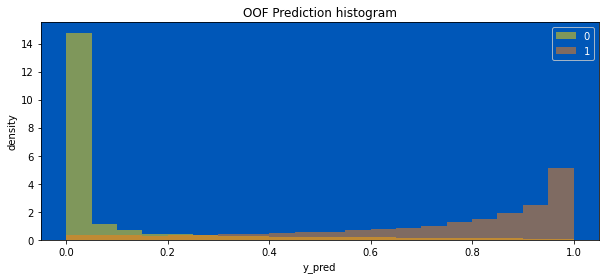

In [10]:
plt.figure(figsize=(10, 4))
plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='0')
plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

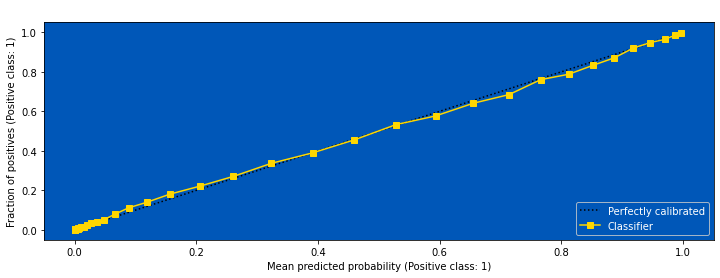

In [11]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

In [12]:
if CFG['make_submit']:
    sub = pd.DataFrame({'customer_ID': test_data.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission_v1.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.018035
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000684
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.020189
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.304872
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.887226
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.017495
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.735137
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.536987
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.311232
